# CoDA (uncertainty‑aware) — OSM Fig. 4c/4i/4j with **CSCG‑style color‑coded states**

**New:** CSCG‑style node colors (uniform gray arrows), three coloring modes (`blocks`, `state_id`, `obs_step`).

In [10]:

import math, random
from dataclasses import dataclass
from typing import Dict, List, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle

try:
    from mpmath import betainc, erfcinv
    _HAS_MPMATH = True
except Exception:
    _HAS_MPMATH = False

random.seed(0); np.random.seed(0)


In [11]:

def posterior_prob_p_greater_than(theta: float, success: float, failure: float, alpha0: float=0.5, beta0: float=0.5) -> float:
    if not _HAS_MPMATH:
        return 0.0
    a = alpha0 + max(0.0, float(success))
    b = beta0 + max(0.0, float(failure))
    cdf = betainc(a, b, 0, theta, regularized=True)
    return float(1.0 - cdf)

def wilson_lower_bound(phat: float, n: float, confidence: float=0.95) -> float:
    if n <= 0:
        return 0.0
    if _HAS_MPMATH:
        z = float((2.0**0.5) * erfcinv(2*(1.0-confidence)))
    else:
        z = 1.6448536269514722
    denom = 1.0 + (z*z)/n
    center = phat + (z*z)/(2.0*n)
    adj = z * ((phat*(1.0-phat) + (z*z)/(4.0*n))/n)**0.5
    return (center - adj)/denom


In [12]:

near = [1,1,1,1,1,1, 2,2,2,2, 1,1,1, 4, 6, 1,1,1, 5,5, 1,1, 7, 0,0,0]
far  = [1,1,1,1,1,1, 3,3,3,3, 1,1,1, 4,4, 1,1,1, 5, 6, 1,1, 7, 0,0,0]

preR1_idx = list(range(10,13))
preR2_idx = list(range(15,18))

def block_indices(rows, cols): return [(r,c) for r in rows for c in cols]
offdiag_pairs     = block_indices(preR1_idx, preR2_idx) + block_indices(preR2_idx, preR1_idx)
same_preR1_pairs  = block_indices(preR1_idx, preR1_idx)
same_preR2_pairs  = block_indices(preR2_idx, preR2_idx)


In [13]:

@dataclass
class UncCfg:
    gamma: float = 0.9
    lam: float = 0.8
    theta_split: float = 0.85
    confidence: float = 0.95
    alpha0: float = 0.25
    beta0: float = 0.25
    n_threshold: int = 5
    min_presence_episodes: int = 3
    min_effective_exposure: float = 10.0
    reset_symbols: tuple = (0,)

class CoDAUncAgent:
    def __init__(self, obs_symbols, cfg: UncCfg=UncCfg()):
        self.cfg = cfg
        self.reset_symbols = set(cfg.reset_symbols)
        self.states: Dict[int, Dict] = {}
        self.obs_to_state_ids: Dict[int, List[int]] = {o: [] for o in obs_symbols}
        sid=0
        for o in obs_symbols:
            self.states[sid]={'obs':o,'path':None,'parent':None}
            self.obs_to_state_ids[o].append(sid); sid+=1
        self._next_sid=sid
        self.us_classes=[4,5]
        self.co_occ={s:{u:0.0 for u in self.us_classes} for s in self.states}
        self.exposure={s:0.0 for s in self.states}
        self.presence_episodes={s:0 for s in self.states}
        self.salient={}
    
    def _ensure(self, sid): 
        if sid not in self.co_occ:
            self.co_occ[sid]={u:0.0 for u in self.us_classes}
            self.exposure[sid]=0.0
            self.presence_episodes[sid]=0
    
    def _clone_state(self, orig_state_id:int, path:str)->int:
        orig=self.states[orig_state_id]
        cid=self._next_sid
        self.states[cid]={'obs':orig['obs'],'path':path,'parent':orig_state_id}
        self.obs_to_state_ids[orig['obs']].append(cid)
        self._ensure(cid)
        self._next_sid+=1
        return cid
    
    def _select_state_for_obs(self, obs:int, context:Optional[str])->int:
        cands=self.obs_to_state_ids[obs]
        if context is not None:
            for sid in cands:
                if self.states[sid]['path']==context:
                    return sid
        for sid in cands:
            if self.states[sid]['path'] is None: return sid
        return cands[0]
    
    def run_episode(self, obs_seq:List[int], learn=True):
        context=None; latent_seq=[]; visited=set()
        for obs in obs_seq:
            sid=self._select_state_for_obs(obs, context)
            latent_seq.append(sid); visited.add(sid)
            if sid in self.salient: context=self.salient[sid]
            if obs in self.reset_symbols: context=None
        if not learn: return latent_seq
        
        for sid in visited: self.presence_episodes[sid]=self.presence_episodes.get(sid,0)+1
        
        us_positions={4:[i for i,o in enumerate(obs_seq) if o==4],
                      5:[i for i,o in enumerate(obs_seq) if o==5]}
        for u, pos_list in us_positions.items():
            for t_us in pos_list:
                e=np.zeros(self._next_sid, dtype=float)
                for t in range(t_us+1):
                    sid=latent_seq[t]; e *= (self.cfg.gamma*self.cfg.lam); e[sid]+=1.0
                for s_id, val in enumerate(e):
                    if val>0 and s_id in self.states:
                        self._ensure(s_id); self.co_occ[s_id][u]+=val; self.exposure[s_id]+=val
        
        P={}
        for s in self.states:
            tot=sum(self.co_occ[s][u] for u in self.us_classes)
            P[s]={u:(self.co_occ[s][u]/tot if tot>0 else 0.0) for u in self.us_classes}
        
        newly_salient=[]
        for s in list(self.states.keys()):
            if s in self.salient: continue
            tot=sum(self.co_occ[s][u] for u in self.us_classes)
            if tot<self.cfg.n_threshold: continue
            if self.presence_episodes.get(s,0)<self.cfg.min_presence_episodes: continue
            if self.exposure.get(s,0.0)<self.cfg.min_effective_exposure: continue
            u_star=max(self.us_classes, key=lambda u:P[s][u])
            success=self.co_occ[s][u_star]; failure=tot-success
            phat=success/(tot if tot>0 else 1.0)
            post=posterior_prob_p_greater_than(self.cfg.theta_split, success, failure, self.cfg.alpha0, self.cfg.beta0)
            pass_test=(post>=self.cfg.confidence) if post>0 else (wilson_lower_bound(phat, tot, self.cfg.confidence)>self.cfg.theta_split)
            if pass_test:
                path='R1' if u_star==4 else 'R2'
                self.salient[s]=path; newly_salient.append((s,path))
        
        for s,path in newly_salient:
            context=None
            for t,obs in enumerate(obs_seq[:-1]):
                sid=self._select_state_for_obs(obs, context)
                if sid==s:
                    nxt_obs=obs_seq[t+1]
                    cands=self.obs_to_state_ids[nxt_obs]
                    if not any(self.states[c]['path']==path for c in cands):
                        self._clone_state(cands[0], path)
                if sid in self.salient: context=self.salient[sid]
                if obs_seq[t+1] in self.reset_symbols: context=None
        
        return latent_seq
    
    def encode_sequence(self, obs_seq:List[int])->np.ndarray:
        lat=self.run_episode(obs_seq, learn=False)
        S=self._next_sid
        X=np.zeros((len(lat),S), dtype=float)
        for t,sid in enumerate(lat): X[t,sid]=1.0
        return X[:,:self._next_sid]
    
    def near_far_corr(self, near_seq, far_seq)->np.ndarray:
        A=self.encode_sequence(near_seq); B=self.encode_sequence(far_seq)
        C=np.zeros((A.shape[0], B.shape[0]))
        for i in range(A.shape[0]):
            for j in range(B.shape[0]):
                a=A[i]; b=B[j]
                if np.allclose(a,0) or np.allclose(b,0): C[i,j]=0.0; continue
                a0=a-a.mean(); b0=b-b.mean()
                den=(np.linalg.norm(a0)*np.linalg.norm(b0))
                C[i,j]=(a0@b0)/den if den>0 else 0.0
        return C


In [14]:

N_RUNS=6; SESSIONS=9; TRIALS_PER_SESSION=0; THRESH=0.3
def block_mean(C, pairs): 
    return float(np.mean([C[i,j] for (i,j) in pairs])) if pairs else np.nan
rng=np.random.default_rng(123)
all_final_blocks=[]; all_time_to_thr=[]; mat_by_session={s:[] for s in [1,3,4,9]}
checkpoint_sessions=[1,3,4,9]; demo_checkpoints={}

for run in range(N_RUNS):
    agent=CoDAUncAgent(obs_symbols=sorted(set(near)|set(far)), cfg=UncCfg())
    tt={'offdiag':None,'preR2':None,'preR1':None}
    for session in range(1, SESSIONS+1):
        episodes=[near]*(TRIALS_PER_SESSION//2)+[far]*(TRIALS_PER_SESSION//2)
        rng.shuffle(episodes)
        for ep in episodes: agent.run_episode(ep, learn=True)
        C=agent.near_far_corr(near, far)
        if session in mat_by_session: mat_by_session[session].append(C)
        if run==0 and session in checkpoint_sessions:
            snap=CoDAUncAgent(obs_symbols=sorted(set(near)|set(far)), cfg=agent.cfg)
            snap.states={k:v.copy() for k,v in agent.states.items()}
            snap._next_sid=agent._next_sid
            snap.obs_to_state_ids={k:list(v) for k,v in agent.obs_to_state_ids.items()}
            snap.co_occ={k:dict(v) for k,v in agent.co_occ.items()}
            snap.exposure=dict(agent.exposure); snap.presence_episodes=dict(agent.presence_episodes)
            snap.salient=dict(agent.salient); demo_checkpoints[session]=snap
        b_off=block_mean(C,offdiag_pairs); b_r2=block_mean(C,same_preR2_pairs); b_r1=block_mean(C,same_preR1_pairs)
        if tt['offdiag'] is None and b_off<THRESH: tt['offdiag']=session
        if tt['preR2']  is None and b_r2<THRESH: tt['preR2']=session
        if tt['preR1']  is None and b_r1<THRESH: tt['preR1']=session
    C_final=agent.near_far_corr(near, far)
    all_final_blocks.append((run, block_mean(C_final, offdiag_pairs), block_mean(C_final, same_preR2_pairs), block_mean(C_final, same_preR1_pairs)))
    def norm(x): return x/SESSIONS if x is not None else np.nan
    all_time_to_thr.append((run, norm(tt['offdiag']), norm(tt['preR2']), norm(tt['preR1'])))

blocks_df=pd.DataFrame(all_final_blocks, columns=['run','offdiag','preR2','preR1']).set_index('run')
times_df =pd.DataFrame(all_time_to_thr, columns=['run','offdiag_t','preR2_t','preR1_t']).set_index('run')


In [15]:

def canonical_latents(agent, seq):
    lat = agent.run_episode(seq, learn=False)
    out = []
    for t,(obs,sid) in enumerate(zip(seq, lat)):
        if obs==0: break
        out.append((t, obs, sid, agent.states[sid]['path']))
    return out

def ring_positions(T: int, r_base=1.0, r_near=1.12, r_far=0.88, start_angle=np.pi/2):
    pos_by_t = {}
    for t in range(T):
        theta = start_angle - 2*np.pi*(t / max(T,1))
        pos_by_t[t] = {'theta': theta,
                       'base': (r_base*np.cos(theta), r_base*np.sin(theta)),
                       'R1':   (r_near*np.cos(theta), r_near*np.sin(theta)),
                       'R2':   (r_far*np.cos(theta),  r_far*np.sin(theta))}
    return pos_by_t

def build_color_assignments(scheme:str, near_lat, far_lat):
    import matplotlib as mpl
    tab20 = mpl.cm.get_cmap('tab20')
    hsv   = mpl.cm.get_cmap('hsv')
    colors={}
    def set_color(lat_seq, fn):
        for (t, obs, sid, path) in lat_seq:
            ring = 'base' if path is None else path
            colors[(t, ring)] = fn(t, obs, sid, ring)
    if scheme=='state_id':
        set_color(near_lat, lambda t,o,s,ring: tab20(s%20))
        set_color(far_lat,  lambda t,o,s,ring: tab20(s%20))
    elif scheme=='obs_step':
        set_color(near_lat, lambda t,o,s,ring: hsv((t%26)/26.0))
        set_color(far_lat,  lambda t,o,s,ring: hsv((t%26)/26.0))
    else:
        col_magenta='#cf4ea6'; col_green='#7cc578'; col_blue='#3b6ea8'; col_grey='#9c9c9c'; col_black='#111'
        set_color(near_lat, lambda t,o,s,ring: col_grey); set_color(far_lat, lambda t,o,s,ring: col_grey)
        for t in [6,7,8,9]: colors[(t,'base')] = col_blue
        for t in [*preR1_idx]: 
            colors[(t,'base')] = col_magenta; colors[(t,'R1')] = col_magenta; colors[(t,'R2')] = col_magenta
        for t in [*preR2_idx]:
            colors[(t,'base')] = col_green; colors[(t,'R1')] = col_green; colors[(t,'R2')] = col_green
        for t in [22]: 
            colors[(t,'base')] = col_black; colors[(t,'R1')] = col_black; colors[(t,'R2')] = col_black
    return colors

def draw_cscg_style_ring(ax, agent, title=None, scheme='blocks',
                         close_loop=True,    # <— NEW: connect last→first
                         edge_color='#6a6a6a', edge_lw=1.2):
    # --- build sequences and ring geometry ---
    near_lat = canonical_latents(agent, near)
    far_lat  = canonical_latents(agent, far)
    T = max(len(near_lat), len(far_lat))
    pos = ring_positions(T)  # same function you already have

    # --- node colors (unchanged from your v4_colors notebook) ---
    node_colors = build_color_assignments(scheme, near_lat, far_lat)

    def draw_edges(lat_seq, z=1):
        # consecutive chords
        for i in range(len(lat_seq)-1):
            t,  _, _, p  = lat_seq[i]
            t2, _, _, p2 = lat_seq[i+1]
            r1 = 'base' if p  is None else p
            r2 = 'base' if p2 is None else p2
            x1,y1 = pos[t][r1]; x2,y2 = pos[t2][r2]
            ax.add_patch(FancyArrowPatch((x1,y1),(x2,y2),
                                         arrowstyle='-|>', mutation_scale=6,
                                         lw=edge_lw, color=edge_color, alpha=0.9,
                                         shrinkA=2, shrinkB=2, zorder=z))
        # NEW: last → first to close the loop
        if close_loop and len(lat_seq) >= 2:
            t0, _, _, p0 = lat_seq[0]
            tL, _, _, pL = lat_seq[-1]
            r0 = 'base' if p0 is None else p0
            rL = 'base' if pL is None else pL
            x1,y1 = pos[tL][rL]; x2,y2 = pos[t0][r0]
            ax.add_patch(FancyArrowPatch((x1,y1),(x2,y2),
                                         arrowstyle='-|>', mutation_scale=6,
                                         lw=edge_lw, color=edge_color, alpha=0.9,
                                         shrinkA=2, shrinkB=2, zorder=z))

    def draw_nodes(lat_seq, z=3):
        for (t, obs, sid, path) in lat_seq:
            ring = 'base' if path is None else path
            x,y = pos[t][ring]
            face = node_colors.get((t, ring), '#bfbfbf')
            ax.add_patch(Circle((x,y), radius=0.045, facecolor=face,
                                edgecolor='#4a4a4a', lw=0.7, alpha=0.98, zorder=z))

    # draw: edges underneath, nodes on top
    draw_edges(near_lat, z=1); draw_edges(far_lat, z=1)
    draw_nodes(far_lat,  z=3); draw_nodes(near_lat, z=4)

    ax.set_aspect('equal'); ax.axis('off')
    ax.set_xlim(-1.55,1.55); ax.set_ylim(-1.55,1.55)
    if title: ax.set_title(title)


/var/folders/s0/k9fg8kp94xl307gydfsd9gf00000gq/T/ipykernel_33749/2909589645.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20 = mpl.cm.get_cmap('tab20')
/var/folders/s0/k9fg8kp94xl307gydfsd9gf00000gq/T/ipykernel_33749/2909589645.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  hsv   = mpl.cm.get_cmap('hsv')


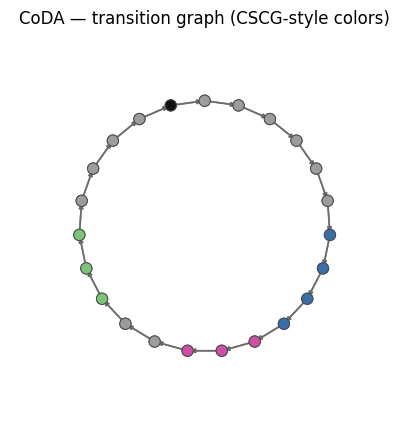

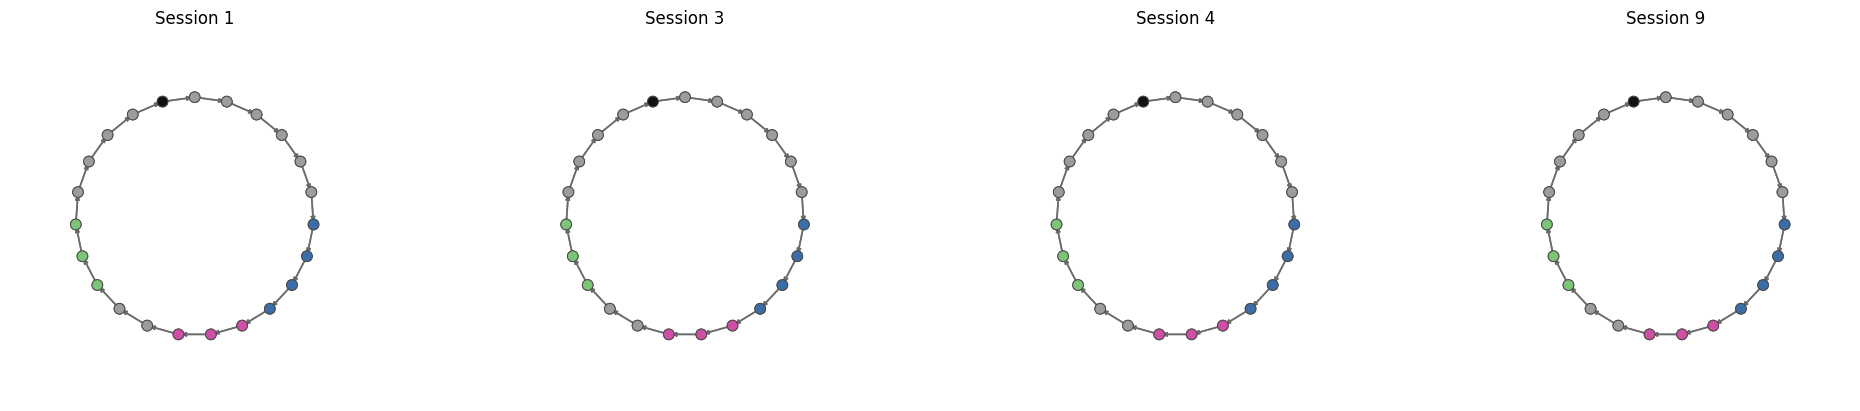

In [16]:

final_session = max([s for s in [1,3,4,9] if s in demo_checkpoints])
fig, ax = plt.subplots(figsize=(6.8,4.2), constrained_layout=True)
draw_cscg_style_ring(ax, demo_checkpoints[final_session], title="CoDA — transition graph (CSCG-style colors)", scheme='blocks')
plt.show()

fig, axes = plt.subplots(1, len(demo_checkpoints), figsize=(4.9*len(demo_checkpoints),4.0), constrained_layout=True)
for ax, s in zip(axes, sorted(demo_checkpoints.keys())):
    draw_cscg_style_ring(ax, demo_checkpoints[s], title=f"Session {s}", scheme='blocks')
plt.show()


/var/folders/s0/k9fg8kp94xl307gydfsd9gf00000gq/T/ipykernel_33749/186084938.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('magma')


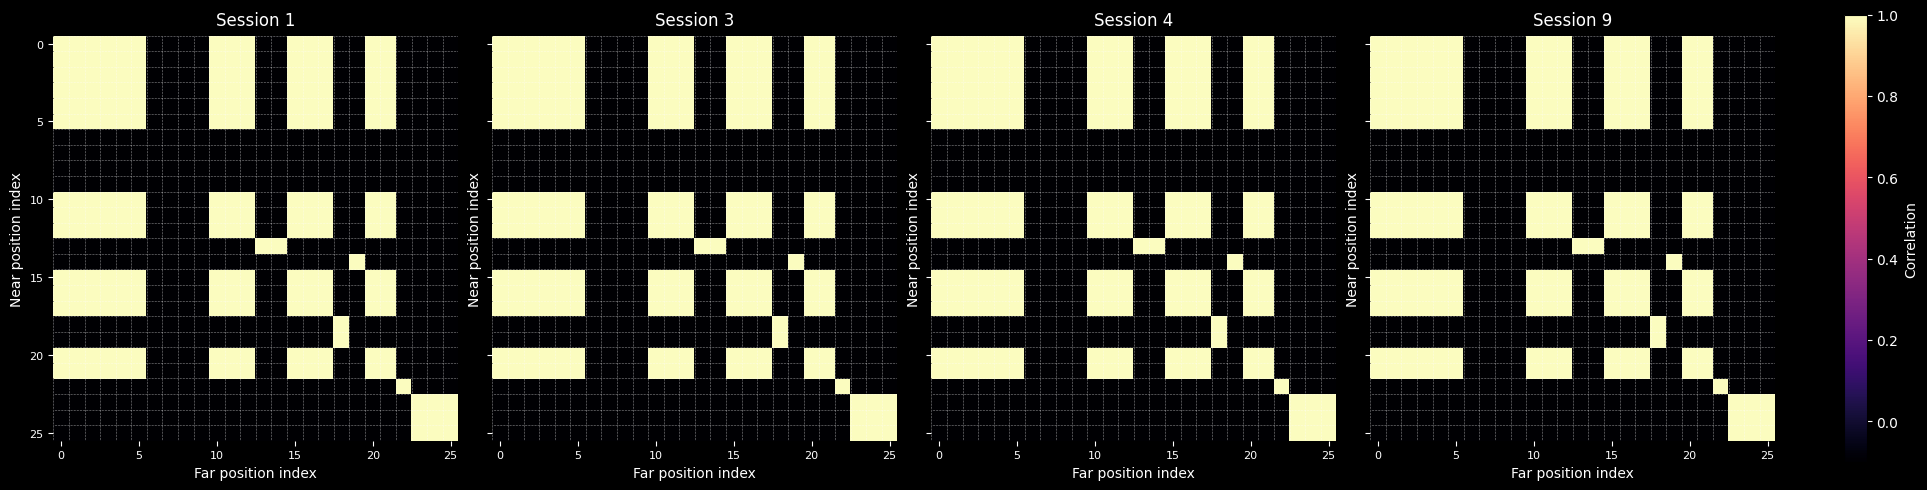

In [17]:
# === Trajectory of decorrelation during learning (CSCG‑style) ===
import matplotlib as mpl

check_sessions = [1, 3, 4, 9]
mean_mats = {s: np.mean(mat_by_session[s], axis=0) for s in check_sessions}

# CSCG-style colormap (dark background, warm high values)
# 'magma' or 'inferno' gives similar look; both start dark→warm→bright
cmap = mpl.cm.get_cmap('magma')

fig, axes = plt.subplots(
    1, len(check_sessions),
    figsize=(4.8 * len(check_sessions), 4.8),
    constrained_layout=True,
    sharex=True, sharey=True
)

vmin, vmax = -0.1, 1.0
last_im = None

for ax, s in zip(axes, check_sessions):
    # origin='upper' puts index (0,0) at top‑left (“start” at top)
    last_im = ax.imshow(
        mean_mats[s],
        vmin=vmin, vmax=vmax,
        cmap=cmap,
        origin='upper',
        aspect='equal',
        interpolation='nearest'
    )
    ax.set_title(f"Session {s}", color='white', pad=8)
    ax.set_xlabel("Far position index", color='white')
    ax.set_ylabel("Near position index", color='white')

    # white dotted grid lines every position index
    ny, nx = mean_mats[s].shape
    ax.set_xticks(np.arange(-0.5, nx, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, ny, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle=':', linewidth=0.4)
    ax.tick_params(colors='white', labelsize=8)
    for spine in ax.spines.values():
        spine.set_visible(False)

# Dark background overall
fig.patch.set_facecolor('black')
for ax in axes:
    ax.set_facecolor('black')

# Shared colorbar with white label/ticks
cbar = fig.colorbar(last_im, ax=axes, fraction=0.046, pad=0.04)
cbar.set_label("Correlation", color='white')
cbar.ax.yaxis.set_tick_params(color='white', labelcolor='white')

plt.show()


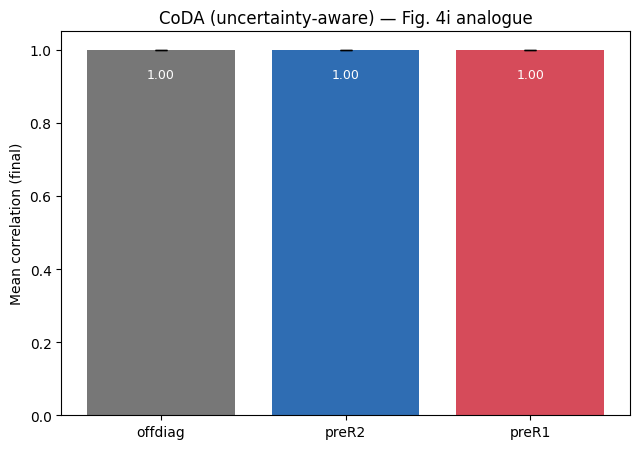

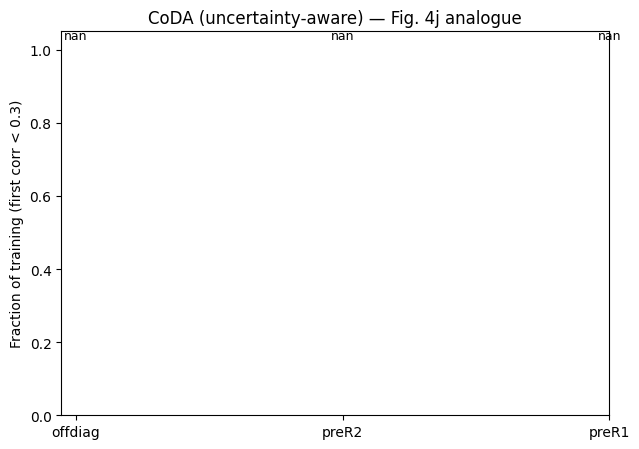

In [18]:

# Fig. 4i
means = blocks_df.mean(); ses = blocks_df.sem()
labels = ['offdiag','preR2','preR1']
x = np.arange(len(labels)); y = [means[l] for l in labels]; yerr = [ses[l] for l in labels]
fig, ax = plt.subplots(figsize=(6.5,4.6))
bars = ax.bar(x, y, yerr=yerr, capsize=4, color=['#777','#2f6db3','#d64b5a'])
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Mean correlation (final)")
ax.set_title("CoDA (uncertainty‑aware) — Fig. 4i analogue")
for i, (b, val) in enumerate(zip(bars, y)):
    ax.text(b.get_x()+b.get_width()/2, (val-0.05 if val>0.85 else min(1.02, val+0.05)), f"{val:.2f}", ha='center',
            va=('top' if val>0.85 else 'bottom'), color=('white' if val>0.85 else 'black'), fontsize=9)
fig.tight_layout(); plt.show()

# Fig. 4j
means_t = times_df.mean(skipna=True); ses_t = times_df.sem(skipna=True)
labels_t = ['offdiag_t','preR2_t','preR1_t']; disp = ['offdiag','preR2','preR1']
x = np.arange(len(labels_t)); y = [means_t[l] for l in labels_t]; yerr = [ses_t[l] for l in labels_t]
fig, ax = plt.subplots(figsize=(6.5,4.6))
bars = ax.bar(x, y, yerr=yerr, capsize=4, color=['#777','#2f6db3','#d64b5a'])
ax.set_xticks(x); ax.set_xticklabels(disp)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Fraction of training (first corr < 0.3)")
ax.set_title("CoDA (uncertainty‑aware) — Fig. 4j analogue")
for i, (b, val) in enumerate(zip(bars, y)):
    ax.text(b.get_x()+b.get_width()/2, min(1.02, val+0.05), f"{val:.2f}", ha='center', va='bottom', fontsize=9)
fig.tight_layout(); plt.show()
